<img src="http://gi-mosm.dem.isel.pt/compdrill/img/logo_isel.png" style="width:300px; float: right; margin: 0 40px 40px 40px;"></img>

### Instituto Superior de Engenharia de Lisboa
### Licenciatura Em Informática e Multimética
# Codificação de Sinais Multimédia

## TRABALHO PRÁTICO 3

Trabalho realizado por:
* Luís Fonseca    - 45125
* João Rodrigues  - 45145
* Rodrigo Matela  - 46316

*Turma 41D*

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Índice

-> [Introdução](#introducao)<br/>
-> [Exercício 1](#ex1)<br/>
-> [Exercício 2](#ex2)<br/>
-> [Exercício 3](#ex3)<br/>
-> [Exercício 4](#ex4)<br/>
-> [Exercício 5](#ex5)<br/>
-> [Exercício 6](#ex6)<br/>
-> [Exercício 7](#ex7)<br/>
-> [Exercício 8,9 e 10](#juncaoUltimosExercicios)<br/>
-> [Conclusão](#conclusao)<br/>
-> [Bibliografia](#bibliografia)

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Introdução <a name="introducao"/>
O terceiro trabalho prático da disciplina de Codificação de Sinais Multimédia tem como objetivo a implementação da norma JPEG, e explorar os seus príncipios básicos para compressão de imagens com perdas.

A norma JPEG é um método comum usado para comprimir imagens fotográficas. O grau de redução pode ser ajustado, o que permite escolher o tamanho de armazenamento e o seu compromisso com a qualidade da imagem. Geralmente obtém-se uma compressão pouco perceptível na perda de qualidade da imagem.

Esta norma foi implementada com dois modos básicos: o método de compressão com perdas, que utiliza um algoritmo baseado na DCT (Discrete Cosine Transform) e um método de compressão sem perdas, que se baseia em métodos preditivos. Como referido anteriormente o método de compressão implementado no trabalho vai introduzir perdas na imagem, logo, baseado na DCT. 

Esta norma contém quatro modos de operação: <br>

-> Sequencial - cada componente da imagem é codificada num único varrimento (de cima para baixo e da esquerda para a direita);

-> Progressivo - a imagem é codificada usando vários varrimentos que produzem uma imagem sucessivamente de melhor qualidade;

-> Hierárquico - a imagem é codificada em várias resoluções de modo a que resoluções mais baixas possam estar acessíveis sem descodificar a resolução mais elevada;


-> Sem perdas - a codificação garante a reconstrução exacta de cada amostra da imagem original. 

Para a realizaão desta norma, o grupo guiou-se pela figura que se apresenta em baixo, seguindo todos os passos. No final são juntados todos os métodos criados para obtenção de resultados e retirar as suas respetivas conclusões. 

<center><img src="https://i.imgur.com/im6BzsA.png" width="95%"></center>

Como pode ser visualizado na imagem em cima, o algoritmo segue estas etapas:
1.	Primeiramente a compressão da imagem no espaço de cores RGB, para YUV, caso a imagem se encontre a cores;
2.	Em seguida, fazer-se-há o DCT (Discrete Cosine Transform) desta mesma imagem por blocos 8x8;
3.	A quantificação é o passo que se segue. Este utiliza uma matriz de quantificação e um nível de qualidade de forma a quantificar a imagem;
4.	A codificação DC;
5.	A codificação AC (em ziguezague);
6.	Por fim, a imagem é codificada num ficheiro e, é feita a inversa destas mesmas etapas. É de notar que a matriz de quantificação é enviada no “cabeçalho” do ficheiro JPEG de forma a poder quantificar inversamente a imagem.


Nota: neste trabalho, como estamos a analisar a imagem em tons de cinzento, não será necessário converter a nossa imagem para yuv, visto que o yuv, apenas é usado para converter imagens em tons de RGB.

Antes de passar para os exercicios deste trabalho, resta citar que utilizaremos o código com os valores das tabelas Q, K3, K5, fator de qualidade e da matriz de zigzag, fornecidos pelo docente, para a realização do trabalho.

De modo a testar o algoritmo implementado neste trabalho, iremos realizar alguns testes sempre que possível. Na parte final do trabalho vão ser analisados os resultados obtidos nos valores da SNR (Signal-to-noise ratio) e as Taxas de Compressão para diferentes fatores de qualidade, bem como o tempo de compressão e descompressão.

Para a realização do trabalho, foi necessário importar algumas bibliotecas, já mencionadas nos trabalhos passados, pelo que não vale a pena realizar uam explicação mais aprofundada das mesmas:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from time import time
import os
from tabelas import Q, K3, K5, quality_factor, zigzag
import re

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## Exercício 1<a name="ex1"/>

Como primeiro exercício, era pedido que fossem realizados dois métodos: uma função (codificador) que para cada bloco de 8x8 da imagem original efectuasse a DCT bidimensional, e outra função (descodificador) que realizasse a DCT inversa.

Antes de passar para a realização destes métodos é necessário conhecer os conceitos de DCT e IDCT.

A transformada *`DCT (Discrete Cosine Transform)`* constitui uma versão discreta da Série de Fourier que usa cosenos como funções de base. *`A DCT`* está relacionada com a *`DFT (Discrete Fourier Transform)`* que consiste numa técnica usada para converter um sinal nas suas frequências elementares, sendo a DCT igualmente calculada usando o eficiente algoritmo Fast Fourier Transform (FFT).

A DCT é uma transformada ortogonal que pode ser expressa através da seguinte expressão analítica:

<center><img src="https://i.imgur.com/dZOB1y7.png"></center>

É usada para transformar as amostras para o domínio da frequência,e tem como característica a concentração de grande parte da energia do sinal nas componentes de baixa frequência. Numa imagem típica, os coeficientes de alta frequência tem amplitude zero ou próxima de zero e não necessitam de ser codificadas.

Este tipo de transformação não introduz perdas nas amostras da imagem dado que é uma transformada reversível; Apenas transforma as amostras para um domínio onde possam ser eficientemente codificadas.

A transformada *`IDCT (inverse Discrete Cosine Transform)`* tem como função redistribuir a energia dos pixeis. Deste modo parte-se de um conjunto de dados sem nenhum tipo de relação (difícil de conseguir ganhos elevados de codificação) e obtêm-se dados agrupados de alguma forma e com bastantes zeros, facilitando a codificação com grandes ganhos.

<center><img src="https://i.imgur.com/SFOYRYv.png"></center>

Com estes conceitos já estudados, passamos então à sua implementação.

Foi criado o método *`DCT(img)`* que permite aplicar a transformada *`DCT`* numa imagem. Esta função recebe como parâmetro uma imagem, que necessita ser recebida em formato `float64`, de modo a ser aceite pela norma da biblioteca `cv2`. De seguida, foi necessário guardar o tamanho da nossa imagem, e colocar dentro um array. Para percorrer a nossa imagem em blocos de 8x8, usamos dois ciclos for, um que irá percorrer as linhas e outro que irá percorrer as colunas da imagem. Procedemos depois à repartição da nossa imagem em blocos de 8x8, como já referido, o que pode ser visto nesta linha: *`bloco = img[i:i+8,j:j+8]`*.

De seguida, com o bloco criado usamos o método *`cv2.dct`* que aplica a transformada *`DCT`*, recorrendo à biblioteca *`cv2`*. No final, é retornado um array, com o bloco de 8x8 criado, passando a transformada *`DCT`*.

A realização do método *`IDCT(dct,img)`* é idêntica ao método de cima, com a exceção de que o parâmetro de entrada recebe a transformada *`DCT`*, e iremos aplicar no nosso bloco de 8x8 a transformada *`IDCT`*, que consiste no inverso da transformada *`DCT`*. Para isso a única linha que é necessário mencionar é a seguinte: *`inversa = cv2.dct(bloco,np.array(bloco),cv2.DCT_INVERSE)`*. O que isto faz é aplicar a transformada inversa da dct, no nosso bloco de 8x8. Para isso recorremos mais uma vez ao método *`cv2.dct`*, passando como argumentos, o nosso bloco de 8x8, e de seguida,*`cv2.DCT_INVERSE`* que permite realizar a transformada inversa da DCT.

Segue-se o código realizado em baixo:

In [2]:
def DCT(img):
    tam = img.shape
    array_final = np.array(img)
    
    for i in np.arange(0,tam[0],8): 
        for j in np.arange(0,tam[1],8):
            bloco = img[i:i+8,j:j+8]
            bloco_dct = cv2.dct(bloco)
            array_final[i:i+8,j:j+8] = bloco_dct     
    return array_final
    
def IDCT(dct, img):
    tam = img.shape
    array_final = np.array(img)
    
    for i in np.arange(0,tam[0],8): 
        for j in np.arange(0,tam[1],8):
            bloco = dct[i: i+8,j:j+8]
            inversa = cv2.dct(bloco,np.array(bloco),cv2.DCT_INVERSE)
            array_final[i:i+8,j:j+8] = inversa
    return array_final


def ex1(img):
    dct = DCT(img)
    idct = IDCT(dct, img)
    cv2.imwrite("dct.tif", dct)
    cv2.imwrite("idct.tif", idct)

Foi realizado também um teste com a própria imagem da lena:

In [3]:
img = cv2.imread("LenaGray.tif", cv2.IMREAD_GRAYSCALE)
img_20 = np.array(img, dtype = np.float64)
ex1(img_20)

Em baixo fica as imagens obtidas quando se realiza o processo DCT (à esquerda) e IDCT (à direita):

<img src="https://i.imgur.com/H7dRv9H.jpg" width="25%" align="left">
<img src="https://i.imgur.com/ab3KHic.jpg" width="28%" align="right" style="margin-top:-3%;">

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## Exercício 2<a name="ex2"/>
Neste exercício era pedido que fosse realizado uma função (codificador) que para cada bloco de 8×8 de coeficientes da transformação efectuada, faça a divisão pela matriz de quantificação, multiplicada por um factor de qualidade *`q`*, e também uma função (descodificador) que realize a operação inversa da quantificação. No final deste exercício, era pedido para juntar estas funções criadas às anteriores, e verificar qual a *`SNR`* obtida entre a imagem codificada e a imagem original, com os vários fatores de qualidade.

Antes de passar para a realização deste exercício, é necessário entender o conceito de fator de qualidade.

O fator de qualidade tem uma relação de linearidade com a matriz *`Q`*. Ao realizarmos a quantificação, para cada valor da matriz *`Q`* vamos multiplicar o valor do fator de qualidade que queremos.

Para isso, começamos por passar um valor de fator de qualidade que queremos aplicar à nossa imagem. De seguida, dividimos a imagem, que já sofreu o efeito DCT da alínea anterior, em blocos não sobrepostos de 8 por 8. Após efectuar a divisão da imagem, fazemos a quantificação da mesma. Para a realização da quantificação, pegamos em cada coeficiente *`DCT`*, e dividimos pela entrada correspondente na matriz de quantificação, e por fim arredondamos o resultado desta divisão. Este cálculo dá-nos o valor de quantificação do *`DCT`*. Após estes processos, efectuamos então o inverso para voltarmos a obter a imagem "inicial". No fim, iremos verificar o *`SNR`* entre a imagem original, e a imagem quantificada, para ver qual a diferença, em ruído, entre ambas. Neste segundo exercício, efectuamos os passos anteriores para três diferentes valores de fator de qualidade que são respetivamente o 25, o 50 e o 75.

Segue-se então o código utilizado:

In [4]:
def SNR(original,descodificada):
    imageO = original.ravel()
    noise = original.astype(float) - descodificada.astype(float)
    imageA = noise.ravel()

    pOriginal = np.sum(imageO**2.)
    pdescodificada = np.sum(imageA**2.)
    SNR = 10*np.log10(pOriginal/pdescodificada)

    return round(SNR,2)


def Quantificacao(dct,Q,per):
    tam = dct.shape
    array_final = np.array(dct)
    fator_compressao = np.multiply(Q,quality_factor(per))
    
    for i in np.arange(0,tam[0],8): 
        for j in np.arange(0,tam[1],8):
            bloco_dct = dct[i:i+8,j:j+8]
            quantificacao = np.round(np.divide(bloco_dct, fator_compressao))
            array_final[i:i+8,j:j+8] = quantificacao     
    return array_final

def Desquantificacao(quant,Q,per):
    tam = quant.shape
    array_final = np.array(quant)
    fator_compressao = np.multiply(Q,quality_factor(per))

    for i in np.arange(0,tam[0],8): 
        for j in np.arange(0,tam[1],8):
            bloco = quant[i: i+8,j:j+8]
            desquant = np.round(np.multiply(bloco, fator_compressao))
            array_final[i:i+8,j:j+8] = desquant
    return array_final

Segue-se também um exemplo teste para verificar a veracidade do código acima:

In [5]:
print("EXERCICIO 2")
    
fator_qualidade = 25
    
dct = DCT(img_20)
quant = Quantificacao(dct,Q,fator_qualidade)
desquant = Desquantificacao(quant,Q,fator_qualidade)
idct = IDCT(desquant, img_20)
    
print('SNR ' + str(fator_qualidade)+ ':', SNR(img,idct))
cv2.imwrite("DCT_" + str(fator_qualidade) + ".tif", quant)
cv2.imwrite("IDCT_" + str(fator_qualidade) + ".tif", idct)
    
fator_qualidade = 50
    
dct = DCT(img_20)
quant = Quantificacao(dct,Q,fator_qualidade)
desquant = Desquantificacao(quant,Q,fator_qualidade)
idct = IDCT(desquant, img_20)
    
print('SNR ' + str(fator_qualidade)+ ':', SNR(img,idct))
cv2.imwrite("DCT_" + str(fator_qualidade) + ".tif", quant)
cv2.imwrite("IDCT_" + str(fator_qualidade) + ".tif", idct)
    
fator_qualidade = 75
    
dct = DCT(img_20)
quant = Quantificacao(dct,Q,fator_qualidade)
desquant = Desquantificacao(quant,Q,fator_qualidade)
idct = IDCT(desquant, img_20)
    
print('SNR ' + str(fator_qualidade)+ ':', SNR(img,idct))
cv2.imwrite("DCT_" + str(fator_qualidade) + ".tif", quant)
cv2.imwrite("IDCT_" + str(fator_qualidade) + ".tif", idct)
    
print("-------------------------------------------------------------------")

EXERCICIO 2
SNR 25: 28.02
SNR 50: 30.14
SNR 75: 32.21
-------------------------------------------------------------------


Como podes observar, obtemos os seguintes resultados:

<center><img src="https://i.imgur.com/e44CxBY.png"></center>


A interpretação dos valores da SNR deve fazer-se do seguinte modo:

* Valores elevados de SNR significam maior qualidade da imagem, isto é, menos distorção.
* Valores baixos de SNR implicam menor qualidade de imagem, isto é, maior nível de distorção ou perda.

Como é possível observar através dos valores obtidos, a relação sinal-ruído é proporcional ao fator de qualidade utilizado, sendo que, quanto maior a qualidade da imagem, maior o seu valor de SNR. Um aspeto a ter em conta na norma JPEG deve-se ao facto de, apenas existir perdas na quantificação, logo, na terceira fase do trabalho prático, os valores da relação sinal-ruído devem manter-se iguais. Caso isto não aconteça, pode significar problemas na implementação do algoritmo, visto que, a codificação de entropia não introduz perdas na codificação de imagens.

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## Exercício 3<a name="ex3"/>

No exercício 3, foi pedido para realizar a codificação diferencial dos coeficientes DC após a quantificação. Com o conhecimento que adquirimos, sabemos que o valor de DC é o primeiro valor de entrada na matriz dos 8x8 blocos da imagem, ou seja, no *`indice [0][0]`*. Como geralmente existe uma forte correlação entre os coeficientes DC dos blocos 8x8 adjacentes, o coeficiente DC quantificado é codificado como a diferença do termo DC do bloco anterior na ordem de codificação, denominada Modulação por código de pulso diferencial (DPCM).

Segue-se um exemplo meramente didático de um bloco de uma imagem, e a vermelho, a circundar, encontra-se a componente DC desse bloco.

<center><img src="https://i.imgur.com/aNvJYsH.png"></center>
<br/>

Para a realização do codificador, começamos por criar dois for's, que vão percorrer a imagem quantificada. Dentro do segundo for, realizámos a diferença entre componentes DC (DC i - DC i-1), tal como referimos anteriormente, que consiste na subtração do coeficiente DC quantificado pela diferença do termo DC do bloco anterior na ordem de codificação.

De seguida, realizámos um if que verifica se a diferença é negativa ou positiva, caso se obtenha um número negativo, transformamos esse mesmo número em binário, e vamos realizar o complemento do número obtido. Por outro lado, caso o número seja positivo (diferente de zero) não precisamos de realizar o seu complemento, e passamos meramente para binário.

De seguida, temos um if que verifica se o *`bin_dif`* tem algum valor atribuído, caso tenha, iremos calcular o número de bits que são necessários para representar o número binário, da diferença entre componentes DC, e consoante o tamanho necessário, vamos obter a codificação.

Por fim temos um if que verifica se a grandeza do valor binário tem algum valor, caso não tenha vamos juntar a codificação de Huffman para os bits necessários, a fim de representar a diferença de componentes DC com a própria diferença, mas caso a grandeza do binário não tenha nenhum valor atribuído, passamos-lhe o valor de Huffman de índice 0 que neste caso será o 00 (valores da tabela K1 - ou Q - presentes no ficheiro "Tabelas", fornecido pelos docentes).

Estando o codificador realizado, passamos à explicação do descodificador DC. Para tal, realiza-se primeiramente a inicialização de algumas variáveis que vão ser úteis para a execução do descodificador, bem como a inicialização de um array, para os componentes DC descodificados.

Depois realizamos um ciclo while, que corre enquanto o índice criado for menor que o tamanho do array de codificação DC. Depois percorremos um ciclo for, para obtermos a "grandeza" e o "binario" (chave e valor) da tabela K3. Caso o valor da codificação de Huffman para os bits necessários do array seja igual ao valor da mesma variável, mas na tabela K3, então vai buscar a diferença de componentes DC em binário do array. Depois, verifica uma série de condições:

* Se a grandeza for 0, a diferença entre componentes DC é zero

A ser assim, colocamos no array "final", na posição "pos", o valor 0;

* Se a grandeza não for zero, e o primeiro bit for zero

A ser assim, realizamos o inverso do complemento, passamos para inteiro, e obtemos a diferença de componentes DC;

* Se a grandeza não for zero, e o primeiro bit for diferente de zero

A ser assim, passamos para inteiro, e obtemos a diferença de componentes DC.

Consequentemente, atualizamos os índices e saímos do for, caminhando para mais um ciclo do ciclo while.

Para finalizar, realizamos um ciclo for simples, que soma o índice presente ao próximo, para obter a componente DC original seguinte (de modo a reconstruir a componente DC).

Segue-se abaixo o código realizado:

In [6]:
def Complemento(b):
    
    c = []
    for num in b:
        if num == '1': 
            c.append('0')
        elif num == '0': 
            c.append('1')
    bit = ''.join(c)
    return bit

def codificadorDC(quant, K):
    tam = quant.shape
    final = []
    coef_DC_anterior = 0
    
    for lin in np.arange(0,tam[0],8): 
        for col in np.arange(0,tam[1],8): 
            bloco = quant[lin:lin+8,col:col+8]
            diferenca = bloco[0][0] - coef_DC_anterior #DC i+1  - DCi
            
            if diferenca < 0:
                bin_neg = bin(int(diferenca))[2:] 
                bin_dif = Complemento(bin_neg)
            else:
                if(diferenca != 0):
                    bin_dif = bin(int(diferenca))[2:]
            
            if(bin_dif != None):
                grandeza = len(bin_dif)
                bin_grandeza = K[grandeza]
                
            if(bin_grandeza != None):
                codificado = bin_grandeza + bin_dif
            else:
                codificado = K[0]
            
            bin_dif = None
            bin_grandeza = None
            
            final.append(codificado)
            coef_DC_anterior = bloco[0][0]
    
    final2 = ''.join(final)  
    
    return final2


def descodificadorDC(array,K, altura, largura):
    
    final = np.zeros( int( (altura)*(largura) ) )
    
    posSeg = 0
    pos = 0
    
    while posSeg < len(array):        
        for grandeza,binario in K.items():
            if array[posSeg:posSeg+len(binario)] == binario:
                bit = array[posSeg+len(binario):posSeg+len(binario)+grandeza]
                
                if( grandeza == 0):
                    final[pos] = (0)

                if( grandeza != 0 and bit[0] == "0"):
                    final[pos] = ((-(int(Complemento(bit),2))))

                if( grandeza != 0 and bit[0] == "1"):
                    final[pos] = ((int(bit,2)))

                posSeg += len(binario)+grandeza
                pos += 1
                break
    
    final = final.reshape(len(final),)
    
    for i in range(len(final)-1):
        final[i+1] = final[i]+final[i+1]
        
        
    return final

Como podemos observar, foi ainda realizada um função complementar bastante simples, que representa a obtenção do complemento de um número binário, caso este seja negativo aquando do cálculo do mesmo, numa primeira instância.

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## Exercício 4<a name="ex4"/>

Para a realização com sucesso do exercício 4 era pedido para realizar a codificação diferencial dos coeficiente AC após a quantificação e codificação DC. Os restantes coeficientes AC encontram-se ordenados em sequência zig-zag como podemos observar na imagem a baixo, na sequência do exemplo meramente didático apresentado também em cima, na pergunta 3.

<center><img src="https://i.imgur.com/tmqxMj8.png"></center>

Este conceito ajuda a facilitar a codificação da entropia, colocando os coeficientes de baixa frequência antes dos coeficientes de alta frequência. Estes 63 coeficientes AC representam a mudança de cor no bloco. Os coeficientes de baixo valor representam a mudança de cor de baixa frequência ou a mudança gradual de cor na região, enquanto que os coeficientes de elevado valor representam  a mudança de cor de alta frequência ou a cor que muda rapidamente de um píxel para o outro dentro do bloco.

<center><img src="https://i.imgur.com/NgGIElZ.png"></center>

Para a realização da codificação AC, começamos então por ordenar o array *`zig-zag`* pelos índices a percorrer, criamos dois for's que vão percorrer o nosso bloco onde se encontram os coeficientes AC, e fazemos a indexação em zig-zag dos coeficientes AC do bloco que estamos a analisar. Depois, usando o método "flatten", vamos a cada pedaço de 64 em 64 números, realizamos o flatten em ordem F, ou seja, por colunas, e ordenamos esse bloco com o "sort" do zig-zag. Para terminar a codificação, criamos então a parte principal que irá realizar a codificação.

Começamos por criar uma variável a *`true`*, de nome EOB (end-of-block), e passamos esta mesma variável ao método while, para que, enquanto o end-of-block seja true, ele esteja constantemente a realizar os seguintes if's:

* Para o primeiro if, caso se verifique que até ao fim do nosso zig-zag só se vão encontrar mais valores zero, vamos atribuir o valor *`[(0,0)]`*, que indica o EOB, e vamos colocar a variável EOB a *`false`*, e terminar o while;

* No segundo if, temos a verificação se a "run" que estamos a fazer contém mais que quinze zeros seguidos, temos de passar o valor de *`[(15,0)]`*, que indica a "run" máxima da tabela K5;

* O próximo if faz a contagem de zeros da tabela;

* E, por fim, verificamos se o número numa dada posição é positivo ou negativo: caso seja negativo, converte-se o número para binário e depois realiza-se o seu complemento; mas caso seja positivo, apenas é necessário convertê-lo para binário.

Para finalizar, junta-mos estes valores todos num array, e retorna-mo-lo.

Para a realização da descodificação AC, vamos efectuar o processo inverso. Passamos como argumento da função o array obtido na codificação, e criamos um while que corre todo o array da codificação, e comparamos os valores dentro da tabela que se encontram em binário. Se forem iguais aos obtidos na tabela K5, voltamos a converter para um array de blocos em inteiro.

Segue-se o código realizado:

In [7]:
def codificadorAC(quant, K5):
    final = []
    tam = quant.shape

    zigzagOrdered = zigzag.reshape(64,order='F').astype('int')
    sort = np.argsort(zigzagOrdered)      

    for linha in np.arange(0,tam[0],8): 
        for coluna in np.arange(0,tam[1],8):  
            bloco = quant[linha:linha+8,coluna:coluna+8]
            Bloco = bloco.flatten(order='F')
            copia = Bloco[sort]
  
            posSeg = 0
            zeros = 0
            EOB = True          
            
            while(EOB):
                if(sum(abs(copia[posSeg:]))==0):
                    bin_EOB = K5[(0, 0)]
                    final.append(bin_EOB)
                    EOB = False
                    break
                elif(zeros>15):
                    posSeg -= 1
                    cod_huffman = K5[(15,0)]
                    final.append(cod_huffman)
                    zeros = 0    
                elif(copia[posSeg] == 0):
                    zeros += 1
                    posSeg += 1
                else:
                    if(copia[posSeg]<0):
                        #SE FOR NEGATIVO
                        #exemplo para o número "-1": sem o [2:], ficaria '-0b1'. COm [2:] fica 'b1'
                        bin_neg = bin(int(copia[posSeg]))[2:] 
                        #vai buscar o complemento: ex para "-1": binario 1, passa a 0
                        amplitude_bin = Complemento(bin_neg)        
                    else:
                        #SE FOR POSITIVO, apenas basta converter para binário
                        amplitude_bin = bin(int(copia[posSeg]))[2:]
                    
                    grandeza = len(amplitude_bin)    
                    cod_huffman = K5[(zeros,grandeza)]
                    codigo_huffman_AC = cod_huffman + amplitude_bin    
                    final.append(codigo_huffman_AC)
                    zeros = 0
                    posSeg += 1
                    
    final2 = ''.join(final)
                    
    return final2
    
def descodificadorAC(array,K5,altura,largura):
    
    final = np.zeros(8*8)
    posSeg = 0
    pos = 0
    array_blocos = np.zeros(shape=(int(altura*8),int(largura*8)))
    linha = 0
    coluna = 0
    
    while posSeg < len(array):  
        for par_valores, binarios in K5.items():
            if array[posSeg:posSeg + len(binarios)] == binarios:
                run = par_valores[0]
                ampl = par_valores[1]
                pos += run
                posSeg += len(binarios)
                
                if(run == 0 and ampl == 0):
                    if(coluna == (largura*8)):
                        coluna = 0
                        linha += 8
                       
                    array_blocos[linha:linha+8,coluna:coluna+8] = final.reshape(8,8)
                    coluna += 8                    
                    final = np.zeros(8*8)
                    pos = 0
                    
                elif(run!=15 and ampl!=0) or (run!=0 and ampl!=0):
                    bin_conv = array[posSeg:posSeg+ampl]
                    
                    if bin_conv[0] == "0":
                        final[pos] = -(int(Complemento(bin_conv),2))
                    else:
                        final[pos] = int(bin_conv,2)
                    
                    pos += 1
                    posSeg += ampl

                break

    return array_blocos

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## Exercício 5<a name="ex5"/>

Com os métodos criados nos exercícios anteriores, realizámos uma junção dos mesmos, de modo a obter resultados que possamos vir a observar e analisar. Para esta junção de exercícios usamos a seguinte imagem.

<center><img src="https://i.imgur.com/CFdHjbj.png" width="35%"></center>

Começamos então por criar uma *`altura`* e *`largura`* que nos vai indicar o *`shape`* da imagem, e dividimos estes valores pelos criados anteriormente que são os valores *`bloco_width`* e *`bloco_height`*, que são respetivamente 8 e 8, e nos indicam o tamanho da matriz do bloco da nossa imagem.

De seguida, criamos um array ao qual passamos os valores de fator de qualidade que queremos atribuir às imagens que vamos "criar". De seguida, criamos um for que irá percorrer o array de fatores de qualidade, e atribuir os diferentes fatores de qualidade desejados, para obter os diferentes resultados possíveis. Seguem-se os passos a realizar para codificar as imagens:

- Realizar a DCT da imagem;
- Realizar a quantificação do DCT, com o valor do fator de qualidade a ser alterado pelo for;
- Realizar a codificação DC e AC da quantificação, com respetivamente os valores da tabela K3 e K5;
- Realizar as descodificações, tanto DC como AC;
- Inverter o zig-zag criado anteriormente na codificação AC para o original;
- Realizar a desquantificação;
- Realizar o DCT inverso (IDCT);
- Por fim, realizar a escrita da imagem, usando o método *`cv2.imwrite`*.

Após este procedimento, obtemos as imagens que se podem ver a seguir.
<br>
<br>

<center>
<img src="https://i.imgur.com/elCXXtq.jpg" width="25%" align="left">

<img src="https://i.imgur.com/aZB2rwG.jpg" width="25%">

<img src="https://i.imgur.com/FAcXKIV.jpg" width="25%" align="right">
</center>


A imagem à esquerda apresenta um fator de qualidade com 25%, a do centro com fator de qualidade de 50%, e a da direita com valor de 75%.

Analisando as imagens resultantes, e comparando com os valores introduzidos, podemos concluir que à medida que passamos fatores de qualidade mais baixos, a nossa imagem tende a criar mais ruído.

Antes de mostrar o código que permite realizar a codificação, resta apenas realizar dois métodos auxiliares, o método `DCAC`, que permite trocar o bloco DC corretamente codificado pelo primeiro elemento do bloco AC (que estava codificado de modo errado, para depois com esta função ser trocado), e o método `inv_zigzag`, que permite inverter a matriz zigzag obtida da codificação AC, de modo a obter a matriz quantificada original.

In [8]:
def DCAC(codDC, codAC):
    tam = codAC.shape
    x = 0
    
    for lin in np.arange(0,tam[0],8): 
        for col in np.arange(0,tam[1],8): 
            bloco = codAC[lin:lin+8,col:col+8]
            bloco[0][0] = codDC[x]
            codAC[lin:lin+8,col:col+8] = bloco
            x += 1
    
    return codAC

def inv_zigzag(matriz):
    ind_O = zigzag.reshape((64),order='F').astype('int')
    
    tam = matriz.shape
    blocos = np.array(matriz)
    for lin in np.arange(0,tam[0],8): 
        for col in np.arange(0,tam[1],8):  
            bloco = matriz[lin:lin+8,col:col+8].flatten()
            bloco_zz = bloco[ind_O].reshape((8,8),order='F')
            blocos[lin:lin+8,col:col+8] = bloco_zz
    return blocos

Segue-se agora o código realizado para obter a imagem codificada:

In [9]:
img = cv2.imread("LenaGray.tif", cv2.IMREAD_GRAYSCALE)
img_20 = np.array(img, dtype = np.float64)
bloco_width = 8
bloco_height = 8
    
altura, largura = img_20.shape
altura = altura / bloco_height
largura = largura / bloco_width
    
    
fatores_qualidade = [25, 50, 75]
    
for i in range(len(fatores_qualidade)):
    
    #Codificacao 
    dctPic = DCT(img_20)
    dctQuantificado = Quantificacao(dctPic, Q, fatores_qualidade[i])
    codDC = codificadorDC(dctQuantificado, K3)
    codAC = codificadorAC(dctQuantificado, K5)
    
    #Descodificacao
    descDC= descodificadorDC(codDC, K3, altura, largura)   
    descAC = descodificadorAC(codAC, K5, altura, largura)           
    inverso_acs = inv_zigzag(descAC)          
    acsdcs = DCAC(descDC, inverso_acs) 
    desquantificacao = Desquantificacao(acsdcs, Q, fatores_qualidade[i])
    idct = IDCT(desquantificacao, img_20)
        
    cv2.imwrite("Lena_ex5_" + str(fatores_qualidade[i]) + ".tif", idct)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## Exercício 6<a name="ex6"/>

Para este exercício era pedido que fosse criada uma função, que dado as funções das alíneas anteriores (codificação AC e DC), irá usar as tabelas do código de Huffman (tabela K3 e K5) - já realizada nas próprias funções anteriores - e gravar num ficheiro a sequência de bits correspondente.

Para isso foi criado o método *`write2File(ac, dc, filename)`*, que vai receber como parâmetros os coeficientes AC e DC, e o nome do ficheiro onde se irá guardar a informação. A ideia é guardar 4 variáveis juntas: o tamanho da mensagem dos componentes AC totais, os próprios componentes AC, o tamanho da mensagem dos componentes DC totais, e os próprios componentes DC, como se pode ver na seguinte linha de código: *`dcac = ac_len_bin + ac + dc_len_bin + dc`*.

A seguir iremos verificar o tamanho, para realização de bitStuffing (a 8 bits), caso necessário. Para isso, colocamos uma condição que verifica se o tamanho da nossa mensagem (+ 3, devido ao header no início da codificação do ficheiro, indicativo de quantos zeros temos de colocar no fim) é divisível por 8.

No final, após obtermos este array divisível por 8, vamos precisamente dividir o array em partes de 8 bits, converter cada uma delas em inteiro, e guardar num bytearray. Finalmente, guardamos este bytearray no ficheiro de nome indicado no parâmetro da função.

Segue-se então o código executado, produzido pela explicação acima dada:

In [10]:
def write2File(ac, dc, filename):

    dc_len_bin = format(int(len(dc)), '0%db'%20)
    ac_len_bin = format(int(len(ac)), '0%db'%20)
    dcac = ac_len_bin + ac + dc_len_bin + dc
    
    tamanhoRestante = 0
    if((len(dcac) + 3) % 8 != 0):
        tamanhoRestante = 8 - ((len(dcac) + 3) % 8)
        
    header = format(tamanhoRestante, '0%db'%3) 
    zerosAdicionais = tamanhoRestante * '0'
    
    stringFinal = header+dcac+zerosAdicionais
    
    binaryArray = re.findall('[01]{8}', stringFinal)
    intArray = [int(i, 2) for i in binaryArray]
    finalArray = np.array(intArray, dtype = 'uint8')
    byteArray = bytearray(finalArray)
    
    
    newFile = open(filename, "wb")
    # write to file
    newFile.write(byteArray)
    newFile.close()

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## Exercício 7<a name="ex7"/>

Para este exercício era pedido que fosse construída uma função que lesse o ficheiro gravado anteriormente, e retornasse os arrays com os coeficientes AC e DC.

Para isso, foi criado o método *`readFile(filename)`*, que permite ler um ficheiro, quando são gravados os diferentes coeficientes AC e DC.

Para o começo do método, abrimos um ficheiro que contém a mensagem codificada dos métodos anteriores. De seguida, criamos uma variável de nome "fileread", que guarda a informação proveniente do ficheiro. Para tal, fazemos uma operacao and bit a bit, para tornar os bytes em inteiros novamente. Para ler o ficheiro, usamos o método read().

De seguida criamos um array vazio de nome array_8bits, e iniciamos um ciclo for que percorre a dimensão do array de inteiros fileread, lido do ficheiro, e à medida que o for vai iterando, vamos inserindo os valores que se encontram no array fileread, no array_8bits, com formatação de 8 bits (em binário), tal como indica o nome do array.

Para guardar os coeficientes AC e DC, iremos buscar o comprimento de ambas as componentes totais, convertemos em *int*, e realizamos indexações que permitem adquirir somente os componentes AC e DC separados, com sucesso.

Segue-se o código realizado:

In [11]:
def readFile(filename):
    
    with open(filename, 'rb') as ficheiro:
        fileread = [byte for byte in bytearray(ficheiro.read())]
        
        
    array_8bits = []
    for i in range(len(fileread)):
        numero = format(fileread[i], '0%db'%8)
        array_8bits.append(numero)
        
    string_8bits_seguidos = ''.join(array_8bits)
    
    slicer_header = slice(0,3)
    bits_adicionados = int(string_8bits_seguidos[slicer_header], 2)
    slicer_newString_in = slice(3, len(string_8bits_seguidos)-bits_adicionados)
    string_withoutBitStuffing = string_8bits_seguidos[slicer_newString_in]
    array_withoutBitStuffing = list(string_withoutBitStuffing)

    ac_length = int(''.join(array_withoutBitStuffing[:20]),2)
    del(array_withoutBitStuffing[:20])
    
    AC = ''.join(array_withoutBitStuffing[:ac_length])
    del(array_withoutBitStuffing[:ac_length])
    
    dc_length = int(''.join(array_withoutBitStuffing[:20]),2)
    del(array_withoutBitStuffing[:20])
    
    DC = ''.join(array_withoutBitStuffing[:dc_length])


    return AC, DC

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## Exercício 8,9 e 10<a name="juncaoUltimosExercicios"/>

Para finalizar, decidimos juntar os exercícios 8, 9 e 10 para facilitar a compreensão. Começámos então por realizar o processo idêntico ao exercício 5, em que juntamos as várias funções e verificamos o resultado final, com a alteração que após a codificação DC e AC, é necessáio escrever no ficheiro, e ler do ficheiro, e só depois proceder à descodificação.

Mais uma vez, começamos por realizar o DCT da imagem, a quantificação do DCT, e as codificações DC e AC. Depois, como já referido, antes de realizarmos o processo inverso para obtenção da nova imagem, passamos as codificações AC e DC para um ficheiro usando o método do exercício 6, *`write2File`*, para escrever no ficheiro, e o método do exercício 7, *`readFile`*, para ler do ficheiro. Outra diferenciação do exercício 5, é o facto de irmos realizar taxas de compressão, e calcular também os *`timers`* de codificação e descodificação.

Para complementar o exercício, e possibilitar uma melhor compreensão dos outputs produzidos, inserimos também os gráficos obtidos, respetivamente o gráfico da taxa de compressão em função do SNR, o gráfico da qualidade da imagem em função também do SNR e por fim o gráfico da qualidade em função da taxa de compressão.

Na realização deste exercício tivemos tambem de criar a função *`compressionRate`*, que recebe como argumentos duas imagens e ao dividir o tamanho da imagem inicial com o tamanho da imagem que queremos comparar, conseguimos obter a taxa de compressão da imagem "criada" por nós.

Segue-se abaixo o código realizado:

In [12]:
def compressionRate(img1name, img2name):
    
    sizeO = os.path.getsize(img1name)
    sizeA = os.path.getsize(img2name)
    taxaCompressao = sizeO/sizeA
    
    return taxaCompressao

def ex8910():
    

    img = cv2.imread("LenaGray.tif", cv2.IMREAD_GRAYSCALE)
    img_20 = np.array(img, dtype = np.float64)
    bloco_width = 8
    bloco_height = 8
    
    altura, largura = img_20.shape
    altura = altura / bloco_height
    largura = largura / bloco_width
    
    
    fatores_qualidade = [25, 50, 75]
    snr_arr = []
    taxas_comp = []
    tempos_compressao = []
    tempos_descompressao = []
    
    print("EXERCICIO 8")
    print("-------------------------------------------------------------------")
    
    for i in range(len(fatores_qualidade)):

        filename = "lena_ex8_"+str(fatores_qualidade[i])+".txt"
        dct = DCT(img_20)
        quantificacao = Quantificacao(dct, Q, fatores_qualidade[i])
        
        t0 = time()
    
        codDC = codificadorDC(quantificacao, K3)
        codAC = codificadorAC(quantificacao, K5)
        
        tc = time() -t0
        
        write2File(codAC, codDC, filename)
        ACfromFile, DCfromFile = readFile(filename)
        
        t0 = time()
        
        descDC= descodificadorDC(DCfromFile, K3, altura, largura)
        descAC = descodificadorAC(ACfromFile, K5, altura, largura)
        
        td = time() -t0
                
        #SERVE PARA CONVERTER O MODO ZIG ZAG EM ORIGINAL
        inverso_acs = inv_zigzag(descAC)          
        acsdcs = DCAC(descDC, inverso_acs)
        
        desquantificacao = Desquantificacao(acsdcs, Q, fatores_qualidade[i])
        idct = IDCT(desquantificacao, img_20)
        
        snr = SNR(img,idct)
        print('SNR ' + str(fatores_qualidade[i])+ ':', snr)
        
        cv2.imwrite("Lena_ex8_" + str(fatores_qualidade[i]) + ".jpg", idct)
        
        taxa_compressao = compressionRate("LenaGray.tif", "Lena_ex8_" + str(fatores_qualidade[i]) + ".jpg")
        print("TAXA COMPRESSÃO:"+str(fatores_qualidade[i]) + ":", taxa_compressao)
        
        print("TEMPO DE COMPRESSAO:", tc)
        print("TEMPO DE DESCOMPRESSÃO:", td)
        print("-------------------------------------------------------------------")
        
        snr_arr.append(snr)
        taxas_comp.append(taxa_compressao)
        tempos_compressao.append(tc)
        tempos_descompressao.append(td)
      
    # Grafico SNR / Taxa    
    plt.title("Taxa de compressao em funcao da SNR: ")
    plt.plot(snr_arr, taxas_comp, 'g')
    plt.xlabel('SNR')
    plt.ylabel('Taxa de Compressao')
    plt.grid(color='r', linestyle='-', linewidth=0.5)
    plt.show()
    
    # Grafico SNR / Qualidade
    plt.plot(snr_arr, fatores_qualidade)
    plt.xlabel('SNR')
    plt.ylabel("Qualidade")
    plt.grid(color='r', linestyle='-', linewidth=0.5)
    plt.show()
    
    # Grafico Taxa / Qualidade
    plt.plot(taxas_comp, fatores_qualidade)
    plt.xlabel('Taxa de Compressao')
    plt.ylabel("Qualidade")
    plt.grid(color='r', linestyle='-', linewidth=0.5)
    plt.show()

EXERCICIO 8
-------------------------------------------------------------------
SNR 25: 28.02
TAXA COMPRESSÃO:25: 7.228810055403953
TEMPO DE COMPRESSAO: 0.3083779811859131
TEMPO DE DESCOMPRESSÃO: 0.07678365707397461
-------------------------------------------------------------------
SNR 50: 30.14
TAXA COMPRESSÃO:50: 5.448188466012963
TEMPO DE COMPRESSAO: 0.681936502456665
TEMPO DE DESCOMPRESSÃO: 0.12693524360656738
-------------------------------------------------------------------
SNR 75: 32.21
TAXA COMPRESSÃO:75: 4.263391478224115
TEMPO DE COMPRESSAO: 1.0920791625976562
TEMPO DE DESCOMPRESSÃO: 0.1765763759613037
-------------------------------------------------------------------


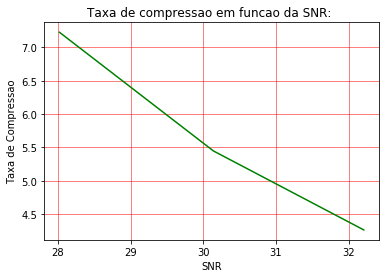

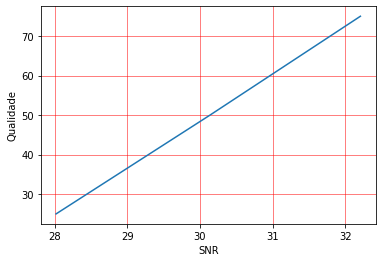

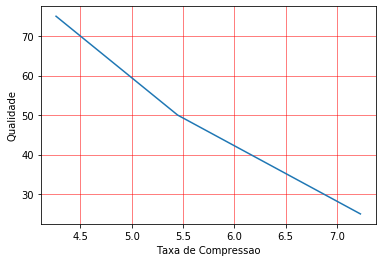

In [13]:
ex8910()

<center><img src="https://i.imgur.com/siPryNV.png" width="80%"></center>

Analisando agora os valores de SNR obtidos, podemos verificar que os valores de SNR do exercício 2 são exactamente iguais aos obtidos neste último exercício, logo, podemos concluir que não existiu perda de informação na codificação de entropia, apenas houve perda na quantificação, ou seja, obtivemos os resultados esperados.

Analisando agora os valores de Taxa de Compressão obtidos, esperávamos que quanto maior fosse o fator de qualidade menor seria o valor da taxa de compressão, e segundo a tabela podemos confirmar que é exactamente isso que acontece.

Por fim analisando os valores do tempo de codificação e descodificação, conseguimos observar que este valores são relativamente baixos, o único ponto de salientar é o aumento proporcional ao fator de qualidade devido ao facto de existirem mais amostras para quantificar.

Após correr o código respetivo, o desenho dos gráficos consegue ser observado acima.

Observando o gráfico da taxa de compressão em função do SNR, conseguimos verificar que quanto menor a taxa de compressão maior vai ser o SNR, ou seja quanto menos comprimida tiver a nossa imagem, melhor qualidade esta vai ter.

Observando o gráfico da qualidade da imagem em função do SNR, a ideia que conseguimos retirar do mesmo é que quanto maior o fator de qualidade for maior vai ser o SNR, logo podemos concluir que existe uma proporcionalidade direta entre o fator de qualidade e o SNR

Observando o gráfico da qualidade em função da taxa de compressão, conseguimos observar o mesmo acontecimento que no primeiro gráfico, uma vez que o SNR e o fator de qualidade têm uma proporcionalidade direta.

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Conclusão<a name="conclusao"/>

Com a realização do trabalho, e os resultados obtidos analisados, podemos concluir que o trabalho foi implementado com sucesso. Os valores referentes às SNR's e Taxas de Compressão são os pretendidos, e mesmo com um fator de compressão de 25% é possível obter uma qualidade de imagem aproximada da original, mas com algum ruído. Apenas quando se desce o fator de qualidade para os 10/15% é que se deixa de ter uma qualidade aceitável (imagem começa a ficar destorcida e impercetível).

No que diz respeito aos tempos de processamento, estes mantiveram-se relativamente baixos, como referido anteriormente. Em suma o grupo obteve conhecimentos referentes à compressão de imagens digitais e o funcionamento da norma JPEG.

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Bibliografia<a name="bibliografia"/>
-> Slides fornecidos pelos docentes da disciplina<br>

-> Norma JPEG,Transformada DCT e IDCT:
    <ul>
        <li>http://www.img.lx.it.pt/~fp/cav/ano2003_2004/Trabalho_3/jpeg2000.htm#htoc2</li>
        <li> https://pt.wikipedia.org/wiki/JPEG </li>
        <li> http://sweet.ua.pt/pedro.figueiredo/projecto/paginas/norma_jpeg.htm </li>
    </ul>
   
